# Forex Prediction-04 (Sequence Models + Plot)

What's new:

1- Using app with enter data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:

df = pd.read_csv('datasets/XAGUSD-H1-rates.csv', sep='\t').dropna()

# Scale selected features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])

# Prepare sequences
def create_sequences(features, target, window, horizon):
    X, y = [], []
    for i in range(window, len(features) - horizon):
        X.append(features[i - window:i])
        y.append(target[i:i + horizon])
    return np.array(X), np.array(y)

WINDOW_SIZE = 30
FORECAST_HORIZON = 10
X, y = create_sequences(scaled, df['<CLOSE>'].values, WINDOW_SIZE, FORECAST_HORIZON)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# Build basic LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(FORECAST_HORIZON)
])
model.compile(optimizer='adam', loss='mse')


# Train
model.fit(X_train, y_train, epochs=1, verbose=1)

# Predict and plot
y_pred = model.predict(X_test)

/home/saeed/repozitories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1377/1377 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 128.2403
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


# plot section

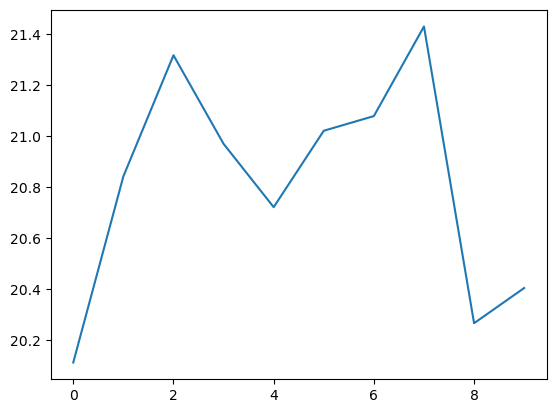

In [4]:
plt.plot(range(10), y_pred[0])
plt.show()


In [6]:
from utils import forex_plot_utils
from datetime import datetime
import os

# PARAMETERS
csv1_path = 'utils/data/111.csv'
csv3_path = 'utils/data/333.csv'
plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None

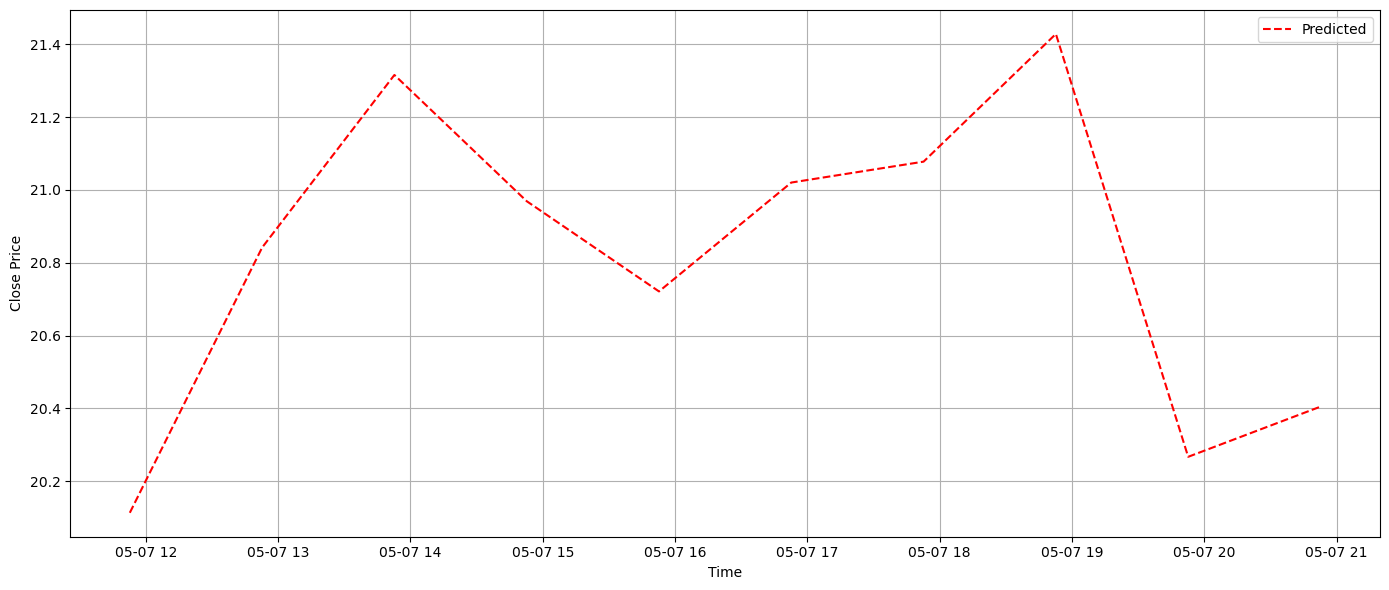

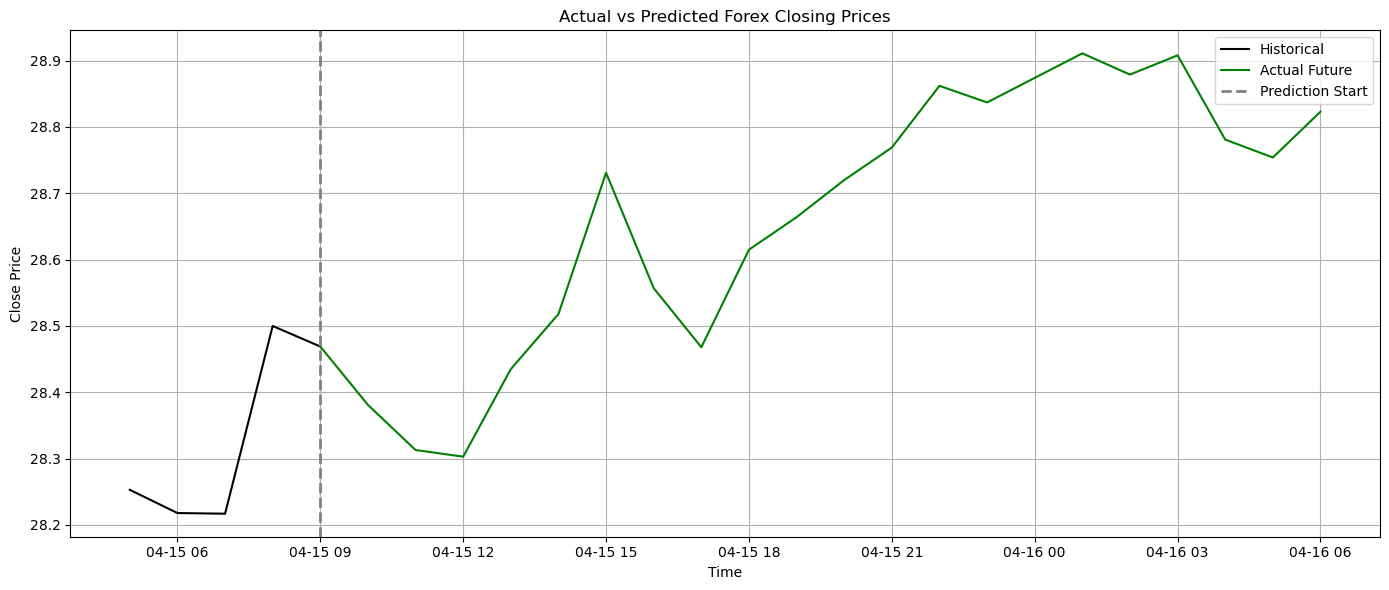

In [7]:
# LOAD DATA
start_time = datetime.now()

# Create datetime index starting from now, one per hour
datetime_index = pd.date_range(start=start_time, periods=len(y_pred[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, '<CLOSE>': y_pred[0]})

# PLOT


# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=forex_plot_utils.plot_all_series(predicted_df=predicted_df),
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)